# Component

A `Component` is like an empty canvas, where you can add polygons, references to other Components and ports (to connect to other components)

![](https://i.imgur.com/oeuKGsc.png)

In gdsfactory **all dimensions** are in **microns**

## Polygons

You can add polygons to different layers. By default all units in gdsfactory are in um.

2024-07-01 15:52:07.604 | WARNING  | kfactory.kcell:show:7783 - klive didn't send data, closing


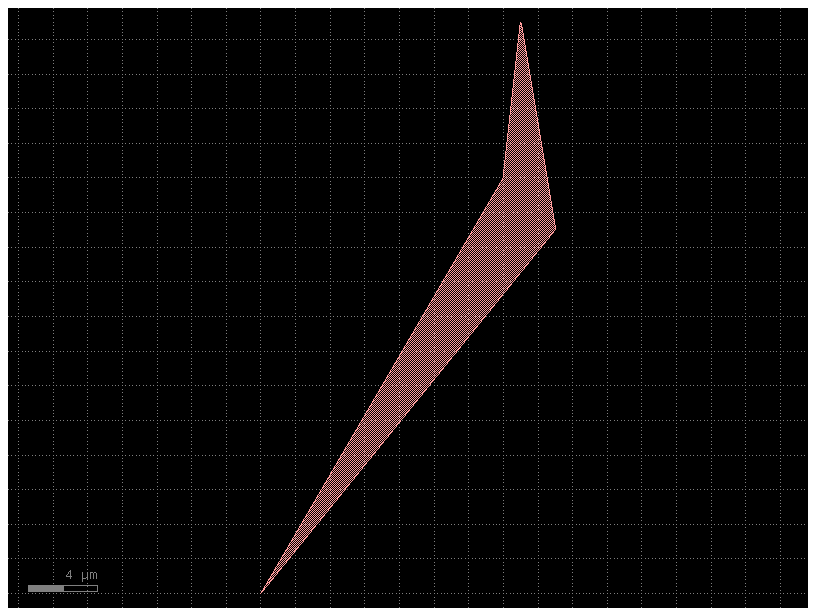

In [3]:
import gdsfactory as gf

c = (
    gf.Component()
)  # Create a blank component (essentially an empty GDS cell with some special features)
p1 = c.add_polygon([(-8, -16), (6, 8), (7, 17), (9, 5)], layer=(1, 0))
c.write_gds("demo.gds")  # write it to a GDS file. You can open it in klayout.
c.show()  # show it in klayout
c.plot()  # plot it in jupyter notebook

**Exercise** :

Make a component similar to the one above that has a second polygon in layer (2, 0)

Unnamed_7: ports [], 3 instances


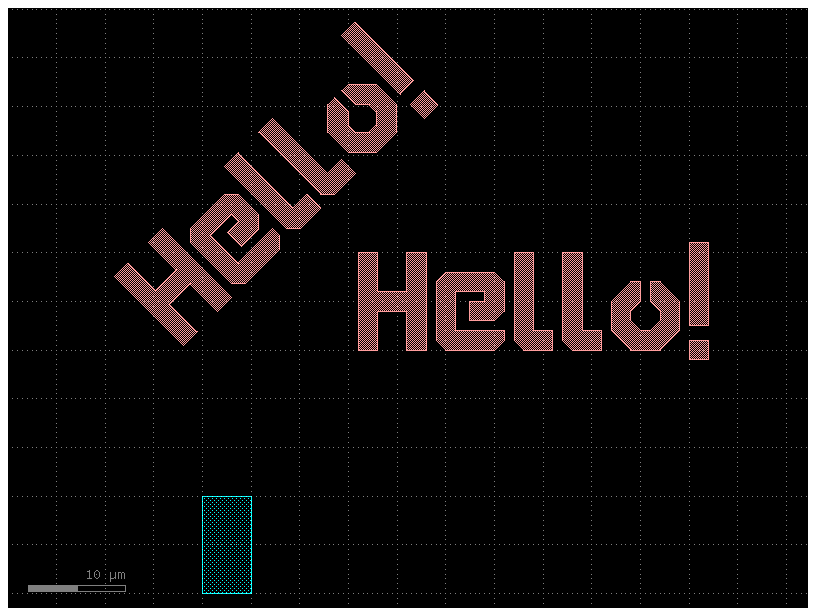

In [4]:
c = gf.Component()

# Create some new geometry from the functions available in the geometry library
t = gf.components.text("Hello!")
r = gf.components.rectangle(size=(5, 10), layer=(2, 0))

# Add references to the new geometry to c, our blank component
text1 = c.add_ref(t)  # Add the text we created as a reference
# Using the << operator (identical to add_ref()), add the same geometry a second time
text2 = c << t
r = c << r  # Add the rectangle we created

# Now that the geometry has been added to "c", we can move everything around:
text1.dmovey(25)
text2.dmove([5, 30])
text2.drotate(45)
r.dmovex(-15)

print(c)
c.plot()

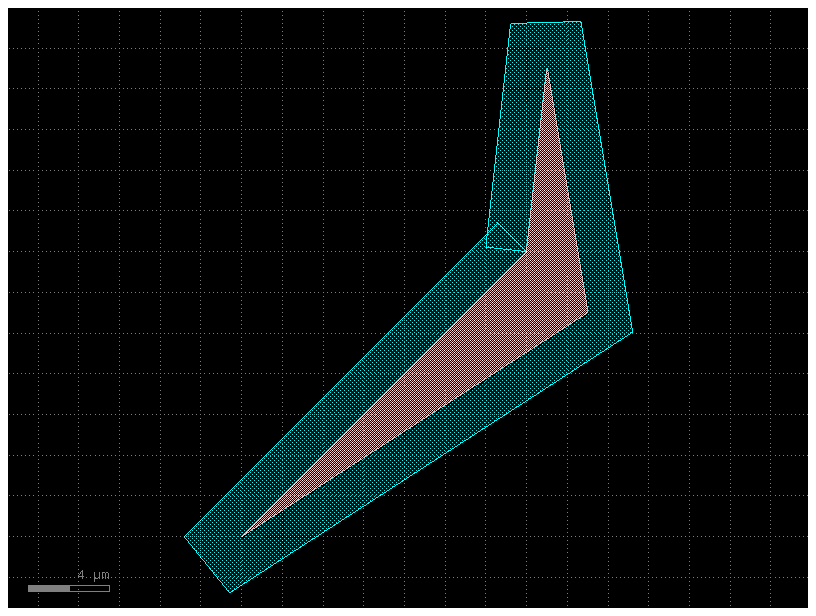

In [6]:
c = gf.Component()
p1 = gf.kdb.DPolygon([(-8, -6), (6, 8), (7, 17), (9, 5)])  # DPolygons are in um
p2 = p1.sized(2)

c.add_polygon(p1, layer=(1, 0))
c.add_polygon(p2, layer=(2, 0))
c.plot()

For operating boolean operations Klayout Regions are very useful.

Notice that Many Klayout objects are in Database Units (DBU) which usually is 1nm, therefore we need to convert a DPolygon (in um) to DBU.

In [7]:
gf.kdb?

Type:        module
String form: <module 'klayout.db' from '/home/erik/anaconda3/envs/py312/lib/python3.12/site-packages/klayout/db/__init__.py'>
File:        ~/anaconda3/envs/py312/lib/python3.12/site-packages/klayout/db/__init__.py
Docstring:   KLayout core module 'db'

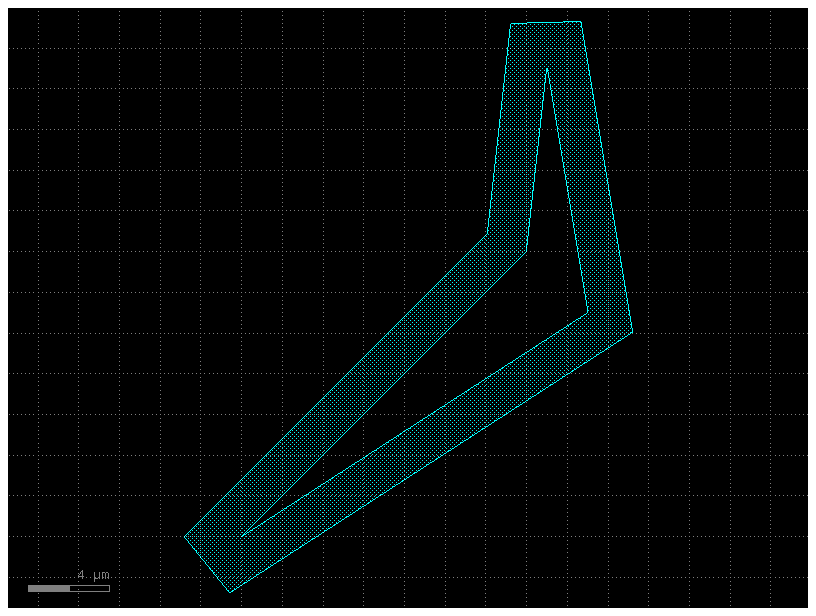

In [8]:
c = gf.Component()
p1 = gf.kdb.DPolygon([(-8, -6), (6, 8), (7, 17), (9, 5)])
r1 = gf.kdb.Region(p1.to_itype(gf.kcl.dbu))  # convert from um to DBU
r2 = r1.sized(2000)  # in DBU
r3 = r2 - r1

c.add_polygon(r3, layer=(2, 0))
c.plot()

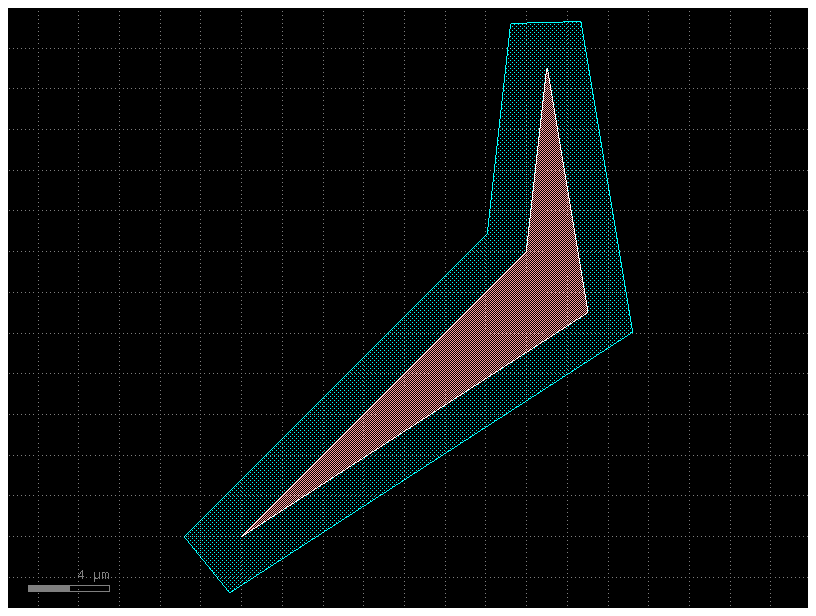

In [9]:
c = gf.Component()
p1 = [(-8, -6), (6, 8), (7, 17), (9, 5)]
s1 = c.add_polygon(p1, layer=(1, 0))
r1 = gf.kdb.Region(s1.polygon)
r2 = r1.sized(2000)  # in DBU, 1 DBU = 1 nm, size it by 2000 nm = 2um
r3 = r2 - r1
c.add_polygon(r3, layer=(2, 0))
c.plot()

## Connect **ports**

Components can have a "Port" that allows you to connect ComponentReferences together like legos.

You can write a simple function to make a rectangular straight, assign ports to the ends, and then connect those rectangles together.

Notice that `connect` transform each reference but things won't remain connected if you move any of the references afterwards.


In [14]:
c.add_port?

Signature:
c.add_port(
    name: 'str | None' = None,
    port: 'kf.Port | None' = None,
    center: 'tuple[float, float] | kf.kdb.DPoint | None' = None,
    width: 'float | None' = None,
    orientation: 'float | None' = None,
    layer: 'LayerSpec | None' = None,
    port_type: 'str' = 'optical',
    keep_mirror: 'bool' = False,
    cross_section: 'CrossSection | None' = None,
) -> 'kf.Port'
Docstring:
Adds a Port to the Component.

Args:
    name: name of the port.
    port: port to add.
    center: center of the port.
    width: width of the port.
    orientation: orientation of the port.
    layer: layer spec to add port on.
    port_type: port type (optical, electrical, ...)
    keep_mirror: if True, keeps the mirror of the port.
    cross_section: cross_section of the port.
File:      ~/anaconda3/envs/py312/lib/python3.12/site-packages/gdsfactory/component.py
Type:      method

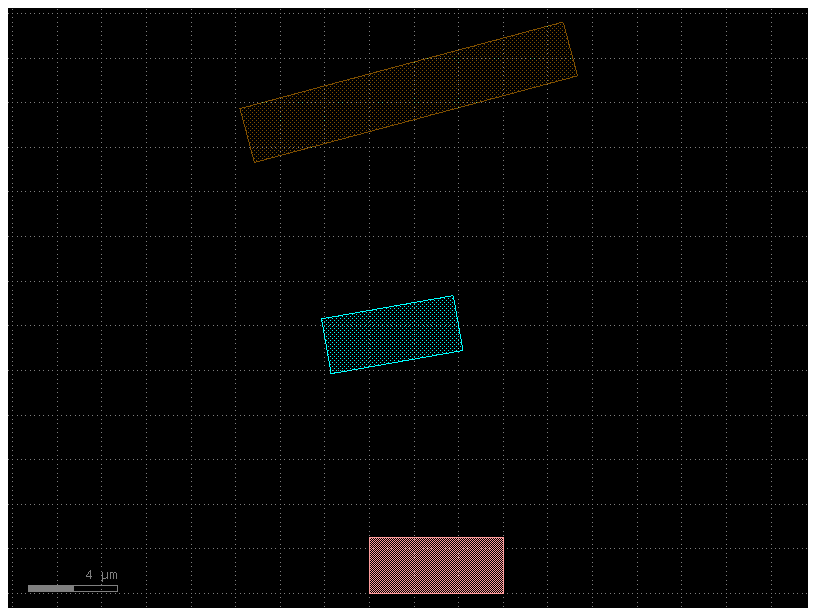

In [10]:
def straight(length=10, width=1, layer=(1, 0)):
    c = gf.Component()
    c.add_polygon([(0, 0), (length, 0), (length, width), (0, width)], layer=layer)
    c.add_port(
        name="o1", center=[0, width / 2], width=width, orientation=180, layer=layer
    )
    c.add_port(
        name="o2", center=[length, width / 2], width=width, orientation=0, layer=layer
    )
    return c


c = gf.Component()

wg1 = c << straight(length=6, width=2.5, layer=(1, 0))
wg2 = c << straight(length=6, width=2.5, layer=(2, 0))
wg3 = c << straight(length=15, width=2.5, layer=(3, 0))
wg2.dmovey(10)
wg2.drotate(10)

wg3.dmovey(20)
wg3.drotate(15)

c.plot()

In [11]:
wg2.dmovex(10)

Unnamed_12: ports ['o1', 'o2'], Unnamed_14: ports ['o1', 'o2'], 0 instances

Now we can connect everything together using the ports:

Each straight has two ports: 'o1' and 'o2', respectively on the East and West sides of the rectangular straight component. These are arbitrary
names defined in our straight() function above

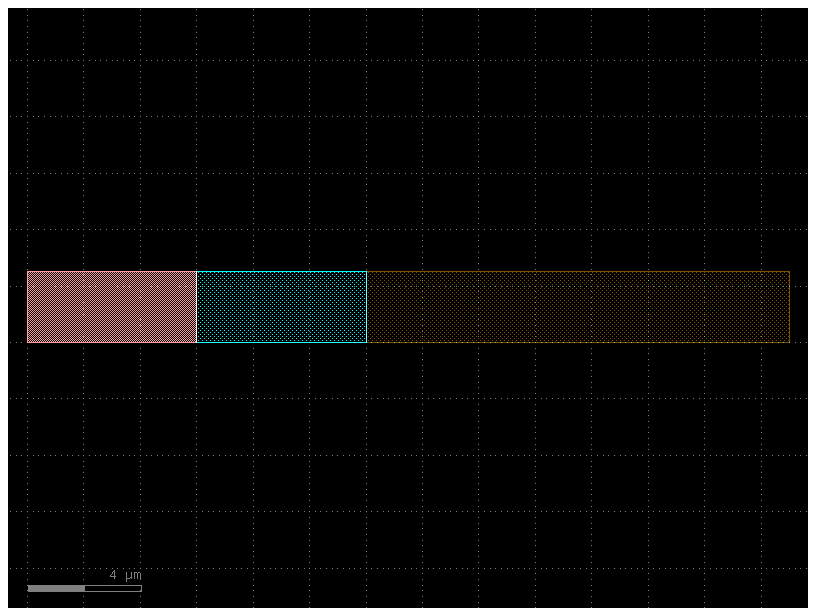

In [12]:
# Let's keep wg1 in place on the bottom, and connect the other straights to it.
# To do that, on wg2 we'll grab the "o1" port and connect it to the "o2" on wg1:
wg2.connect("o1", wg1.ports["o2"], allow_layer_mismatch=True)

# Next, on wg3 let's grab the "o1" port and connect it to the "o2" on wg2:
wg3.connect("o1", wg2.ports["o2"], allow_layer_mismatch=True)

c.plot()

Ports can be added by copying existing ports. In the example below, ports are added at the component-level on c from the existing ports of children wg1 and wg3
(i.e. eastmost and westmost ports)

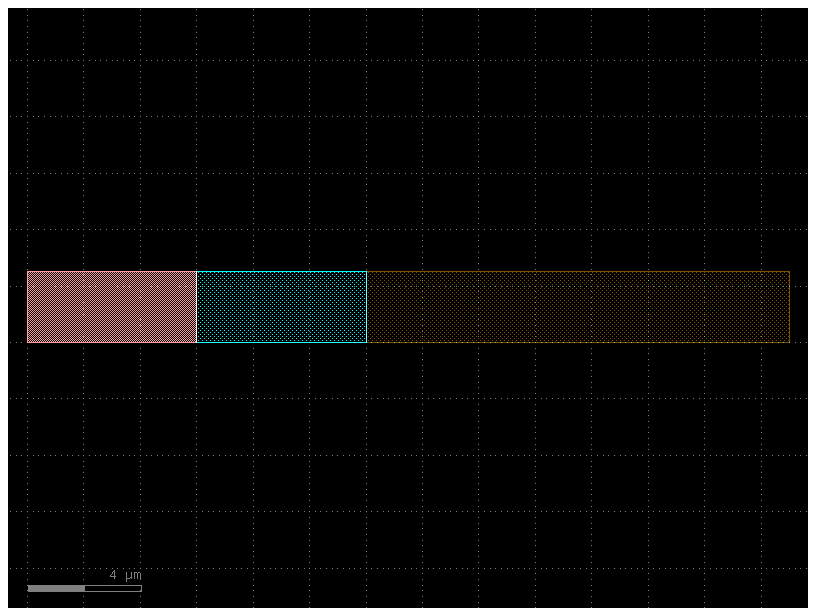

In [15]:
c.add_port("o1", port=wg1.ports["o1"])
c.add_port("o2", port=wg3.ports["o2"])
c.plot()

You can show the ports by adding port pins with triangular shape or using the show_ports plugin

![](https://i.imgur.com/Y3CuM30.png)

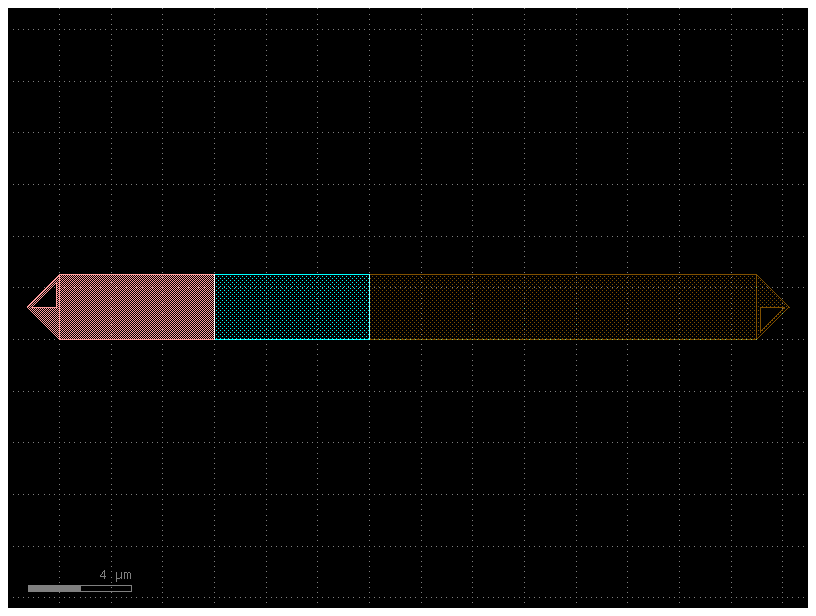

In [16]:
c.draw_ports()
c.plot()

Also you can visualize ports in klayout as the ports are stored in the GDS cell metadata.

## Move and rotate references

You can move, rotate, and reflect references to Components.

There are two main types of movement:

1. Using Integer DataBaseUnits (DBU) (default), in most foundries, 1 DBU = 1nm
2. Using Decimals Floats. Where 1.0 represents 1.0um

In [ ]:
c = gf.Component()

wg1 = c << straight(length=1, layer=(1, 0))
wg2 = c << straight(length=2, layer=(2, 0))
wg3 = c << straight(length=3, layer=(3, 0))

# Shift the second straight we created over by dx = 2, dy = 2 um. D stands for Decimal
wg2.dmove([2.0, 2.0])

# Then, move again the third straight by 3um
wg3.dmovex(3)  # equivalent to wg3.dmove(3)

c.plot()

You can also define the positions relative to other references.

In [ ]:
c = gf.Component()

wg1 = c << straight(length=1, layer=(1, 0))
wg2 = c << straight(length=2, layer=(2, 0))
wg3 = c << straight(length=3, layer=(3, 0))

# Shift the second straight we created over so that the xmin matches wg1.dxmax
wg2.dxmin = wg1.dxmax

# Then, leave a 1um gap with on the last straight
wg3.dxmin = wg2.dxmax + 1

c.plot()

## Ports

Your straights wg1/wg2/wg3 are references to other waveguide components.

If you want to add ports to the new Component `c` you can use `add_port`, where you can create a new port or use a reference to an existing port from the underlying reference.

You can access the ports of a Component or ComponentReference

In [17]:
import gdsfactory as gf


def straight(length=10, width=1, layer=(1, 0)):
    c = gf.Component()
    c.add_polygon([(0, 0), (length, 0), (length, width), (0, width)], layer=layer)
    c.add_port(
        name="o1", center=[0, width / 2], width=width, orientation=180, layer=layer
    )
    c.add_port(
        name="o2", center=[length, width / 2], width=width, orientation=0, layer=layer
    )
    return c

In [18]:
s = straight(length=10)
s.ports

['Port(name: o1, dwidth: 1.0, trans: r180 *1 0,0.5, layer: 1, port_type: optical)', 'Port(name: o2, dwidth: 1.0, trans: r0 *1 10,0.5, layer: 1, port_type: optical)']

In [19]:
s.pprint_ports()

┏━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ name ┃ width ┃ orientation ┃ layer ┃ center      ┃ port_type ┃
┡━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ o1   │ 1.0   │ 180.0       │ 1     │ (0.0, 0.5)  │ optical   │
│ o2   │ 1.0   │ 0.0         │ 1     │ (10.0, 0.5) │ optical   │
└──────┴───────┴─────────────┴───────┴─────────────┴───────────┘

## References

Now that your component `c` is a multi-straight component, you can add references to that component in a new blank Component `c2`, then add two references and shift one to see the movement.

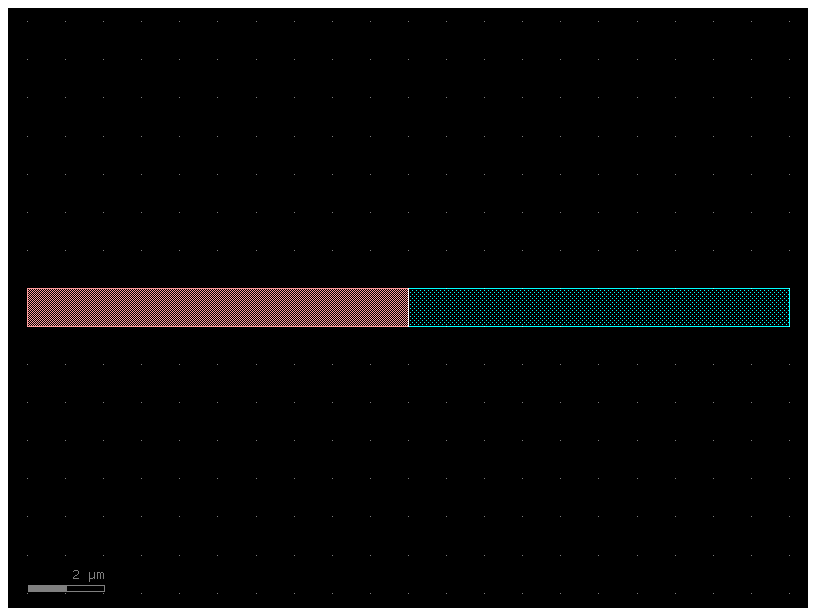

In [20]:
c2 = gf.Component()
wg1 = straight(length=10)
wg2 = straight(length=10, layer=(2, 0))
mwg1_ref = c2.add_ref(wg1)
mwg2_ref = c2.add_ref(wg2)
mwg2_ref.dmovex(10)
c2.plot()

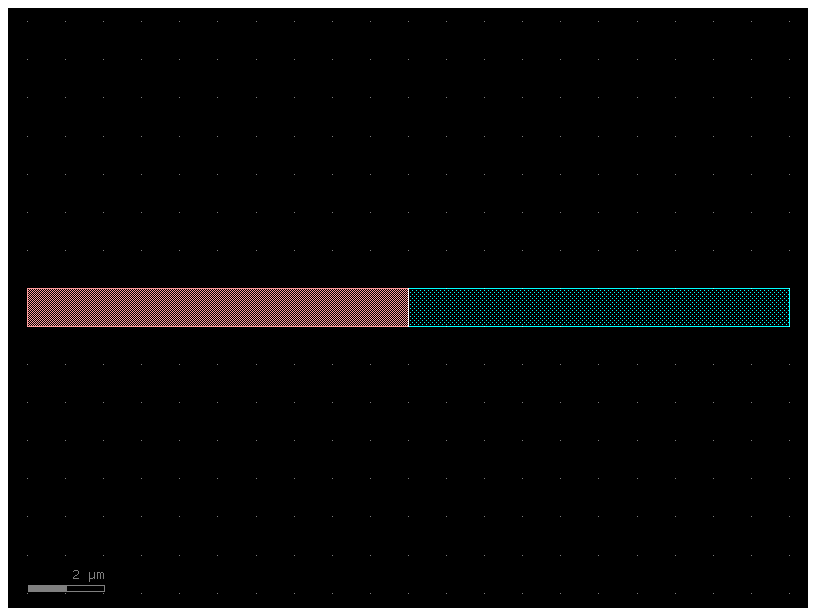

In [21]:
# Like before, let's connect mwg1 and mwg2 together
mwg1_ref.connect(port="o2", other=mwg2_ref.ports["o1"], allow_layer_mismatch=True)
c2.plot()

## Labels

You can add abstract GDS labels to annotate your Components, in order to record information
directly into the final GDS file without putting any extra geometry onto any layer
This label will display in a GDS viewer, but will not be rendered or printed
like the polygons created by `gf.components.text()`.

In [ ]:
c2.add_label(text="First label", position=mwg1_ref.dcenter)
c2.add_label(text="Second label", position=mwg2_ref.dcenter)

# labels are useful for recording information
c2.add_label(
    text=f"The x size of this\nlayout is {c2.dxsize}",
    position=(c2.dx, c2.dy),
    layer=(10, 0),
)
c2.plot()

Another simple example

In [ ]:
c = gf.Component()
r = c << gf.components.rectangle(size=(1, 1))
r.dx = 0
r.dy = 0
c.add_label(
    text="Demo label",
    position=(0, 0),
    layer=(1, 0),
)
c.plot()

## Boolean shapes

If you want to subtract one shape from another, merge two shapes, or
perform an XOR on them, you can do that with the `boolean()` function.


The ``operation`` argument should be {not, and, or, xor, 'A-B', 'B-A', 'A+B'}.
Note that 'A+B' is equivalent to 'or', 'A-B' is equivalent to 'not', and
'B-A' is equivalent to 'not' with the operands switched

In [ ]:
c = gf.Component()
e1 = c.add_ref(gf.components.ellipse(layer=(2, 0)))
e2 = c.add_ref(gf.components.ellipse(radii=(10, 6), layer=(2, 0))).dmovex(2)
e3 = c.add_ref(gf.components.ellipse(radii=(10, 4), layer=(2, 0))).dmovex(5)
c.plot()

In [ ]:
c2 = gf.boolean(A=e2, B=e1, operation="not", layer=(2, 0))
c2.plot()

## Move Reference by port

In [ ]:
c = gf.Component()
mmi = c.add_ref(gf.components.mmi1x2())
bend = c.add_ref(gf.components.bend_circular(layer=(1, 0)))
c.plot()

In [ ]:
bend.connect("o1", mmi.ports["o2"])  # connects follow Source -> Destination syntax
c.plot()

## Mirror reference

By default the mirror works along the y-axis.

In [ ]:
c = gf.Component()
mmi = c.add_ref(gf.components.mmi1x2())
bend = c.add_ref(gf.components.bend_circular())
bend.connect(
    "o1", mmi.ports["o2"], mirror=True
)  # connects follow Source -> Destination syntax
c.plot()

## Write

You can write your Component to:

- GDS file (Graphical Database System) or OASIS for chips.
- gerber for PCB.
- STL for 3d printing.

In [ ]:
import gdsfactory as gf

c = gf.components.cross()
c.write_gds("demo.gds")
c.plot()

You can see the GDS file in Klayout viewer.

Sometimes you also want to save the GDS together with metadata (settings, port names, widths, locations ...) in YAML

In [ ]:
c.write_gds("demo.gds", with_metadata=True)

OASIS is a newer format that can store CAD files and that reduces the size.

In [ ]:
c.write("demo.oas")

You can also save it as STL for 3D printing or for some simulator, thanks to the LayerStack

In [ ]:
gf.export.to_stl(c, "demo.stl")

In [ ]:
scene = c.to_3d()
scene.show()